In [1]:
pip install networkx pandas openpyxl python-louvain sumy


  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached python-louvain-0.16.tar.gz (204 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached sumy-0.11.0-py2.py3-none-any.whl.metadata (7.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
  Using cached docopt-0.6.2-py2.py3-none-any.whl
  Using cached breadability-0.1.20-py2.py3-none-any.whl
  Using cached pycountry-24.6.1-py3-none-any.whl.metadata (12 kB)
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached chardet-5.2.0-py3-none-any.whl.metadata (3.4 kB)
  Using cached lxml-5.3.2-cp311-cp311-win_amd64.whl.meta

In [1]:
# Cell 1: Imports
import pandas as pd
import networkx as nx
import community as community_louvain
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from collections import defaultdict

# Cell 2: Load edge list
df = pd.read_excel("pairwise_similarity.xlsx")
threshold = 0.39

# Cell 3: Build graph using thresholded similarity scores
G = nx.Graph()
for _, row in df.iterrows():
    if row["Similarity Score"] >= threshold:
        G.add_edge(row["Tweet 1"], row["Tweet 2"], weight=row["Similarity Score"])

# Cell 4: Louvain community detection
partition = community_louvain.best_partition(G)
communities = defaultdict(list)
for tweet, community_id in partition.items():
    communities[community_id].append(tweet)

# Cell 5: LexRank summarization function
def summarize(sentences, n=25):
    text = " ".join(sentences)
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = LexRankSummarizer()
    summary = summarizer(parser.document, n)
    return [str(s) for s in summary]

# Cell 6: Generate summaries
community_summaries = {}
for cid, tweets in communities.items():
    community_summaries[cid] = summarize(tweets, n=min(25, len(tweets)))
# Cell 7: Final summary (25-sentence LexRank summary of community summaries)
all_community_sentences = []
for s in community_summaries.values():
    all_community_sentences.extend(s)

final_summary = summarize(all_community_sentences, n=25)


# Cell 8: Save all summaries to Excel
with pd.ExcelWriter("community_summaries_output.xlsx", engine='openpyxl') as writer:
    for cid, summary in community_summaries.items():
        pd.DataFrame(summary, columns=[f"Community {cid} Summary"]).to_excel(writer, sheet_name=f"Community_{cid}", index=False)
    pd.DataFrame(final_summary, columns=["Final Summary"]).to_excel(writer, sheet_name="Final_Summary", index=False)


In [2]:

# Print number of tweets in each community
for cid, tweets in communities.items():
    print(f"Community {cid}: {len(tweets)} tweets")


Community 2: 113 tweets
Community 1: 104 tweets
Community 4: 105 tweets
Community 3: 114 tweets
Community 0: 48 tweets


Total Male-Gendered Terms: 16
Total Female-Gendered Terms: 21
Inclusion Bias Score: 0.1351


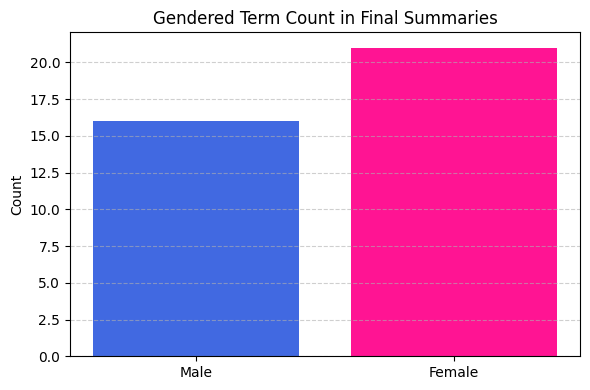

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
file_path = "community_summaries_output.xlsx"
df = pd.read_excel(file_path, sheet_name="Final_Summary")

# Convert summaries to lowercase for consistent matching
df['Final Summary'] = df['Final Summary'].astype(str).str.lower()

# (Keep your full male_terms and female_terms here as provided)
# ... [Your long sets for male_terms and female_terms remain unchanged above] ...

# Function to count gendered terms
def count_gendered_words(text, terms):
    words = text.split()
    return sum(1 for word in words if word.strip('.,!?()[]{};:\'"').lower() in terms)

# Apply counting
df['Male_Count'] = df['Final Summary'].apply(lambda x: count_gendered_words(x, male_terms))
df['Female_Count'] = df['Final Summary'].apply(lambda x: count_gendered_words(x, female_terms))

# Totals
total_male = df['Male_Count'].sum()
total_female = df['Female_Count'].sum()

# Print counts
print("Total Male-Gendered Terms:", total_male)
print("Total Female-Gendered Terms:", total_female)

# Inclusion Bias Score
if total_male + total_female == 0:
    bias_score = 0
else:
    bias_score = (total_female - total_male) / (total_male + total_female)

print(f"Inclusion Bias Score: {bias_score:.4f}")

# Plotting
plt.figure(figsize=(6, 4))
plt.bar(['Male', 'Female'], [total_male, total_female], color=['royalblue', 'deeppink'])
plt.title("Gendered Term Count in Final Summaries")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [5]:
pip install matplotlib

  Using cached pillow-11.1.0-cp311-cp311-win_amd64.whl.metadata (9.3 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 3.4 MB/s eta 0:00:03
   ------ --------------------------------- 1.3/8.1 MB 3.7 MB/s eta 0:00:02
   ---------- ----------------------------- 2.1/8.1 MB 3.8 MB/s eta 0:00:02
   ---------------- ----------------------- 3.4/8.1 MB 4.3 MB/s eta 0:00:02
   -------------------- ------------------- 4.2/8.1 MB 4.3 MB/s eta 0:00:01
   -------------------------- ------------- 5.2/8.1 MB 4.4 MB/s eta 0:00:01
   ----------------------------- ---------- 6.0/8.1 MB 4.4 MB/s eta 0:00:01
   --------------------------------- ------ 6.8/8.1 MB 4.2 MB/s eta 0:00:01
   ------------------------------------- -- 7.6/8.1 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 4.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   -------------- -----------